In [2]:
from zipfile import ZipFile
file_name = 'aug_data.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [57]:
from zipfile import ZipFile
file_name = 'sample.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [33]:
# train_datagen = ImageDataGenerator(
#     rescale = 1./255,
# )
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=50.0,
    fill_mode='nearest'
)

training_set = train_datagen.flow_from_directory(
    'aug_data/train',
    target_size = (224, 224),
    batch_size = 8,
    class_mode = 'categorical',
    shuffle=True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
)

testing_set = test_datagen.flow_from_directory(
    'aug_data/test',
    target_size = (224, 224),
    batch_size = 8,
    class_mode = 'categorical',
    shuffle=False
)

Found 981 images belonging to 7 classes.
Found 242 images belonging to 7 classes.


In [34]:
import collections
class_counts = collections.Counter(training_set.classes)
print(class_counts)

Counter({0: 143, 1: 143, 2: 141, 3: 141, 4: 139, 5: 137, 6: 137})


In [35]:
images, labels = next(training_set)
labels

array([[0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

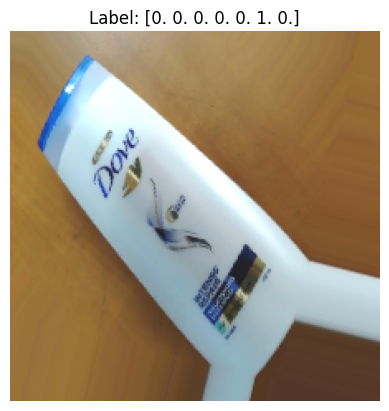

In [36]:
plt.imshow(images[7])
plt.title(f"Label: {labels[0]}")
plt.axis('off')  # Hide the axis
plt.show()

In [37]:
base_model = VGG19(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Freeze the first few layers to retain general features
for layer in base_model.layers[:15]:
    layer.trainable = False

print(base_model.output_shape)

(None, 7, 7, 512)


In [52]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = Sequential([
    Conv2D(8, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'),

    Conv2D(16, kernel_size=(3, 3), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'),

    Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(7, activation='softmax')
])


model.summary()

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-4,
#     decay_steps=10000,
#     decay_rate=0.9
# )
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Define the callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',       # Monitors the validation loss
    factor=0.5,               # Reduces the learning rate by a factor of 0.5
    patience=3,               # Wait for 3 epochs without improvement
    min_lr=1e-6,              # Minimum learning rate to stop reducing
    verbose=1                 # Print updates when learning rate changes
)

early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitors the validation loss
    patience=7,               # Stops training after 7 epochs of no improvement
    restore_best_weights=True # Restores model weights from the best epoch
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)                   │ (None, 222, 222, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 222, 222, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 111, 111, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 109, 109, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 52, 52, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 52, 52, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 64)                  │       1,384,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,393,079 (5.31 MB)

 Trainable params: 1,392,967 (5.31 MB)

 Non-trainable params: 112 (448.00 B)

In [53]:
# history=model.fit(training_set,epochs=10,validation_data=testing_set)
history=model.fit(training_set,epochs=50,validation_data=testing_set, callbacks=[early_stopping, reduce_lr] )

Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 179ms/step - accuracy: 0.2283 - loss: 4.0890 - val_accuracy: 0.2107 - val_loss: 3.6854 - learning_rate: 1.0000e-04
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 35s 150ms/step - accuracy: 0.3109 - loss: 3.4926 - val_accuracy: 0.4008 - val_loss: 3.2981 - learning_rate: 1.0000e-04
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.4266 - loss: 3.2439 - val_accuracy: 0.4793 - val_loss: 2.9845 - learning_rate: 1.0000e-04
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 0.3993 - loss: 3.2254 - val_accuracy: 0.7521 - val_loss: 2.5584 - learning_rate: 1.0000e-04
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.5081 - loss: 2.9841 - val_accuracy: 0.7025 - val_loss: 2.4367 - learning_rate: 1.0000e-04
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - accuracy: 0.5252 - loss: 2.8742 - val_accuracy: 0.8182 - val_loss: 2.2053 - learning_rate: 1.0000e-04
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 18s 14

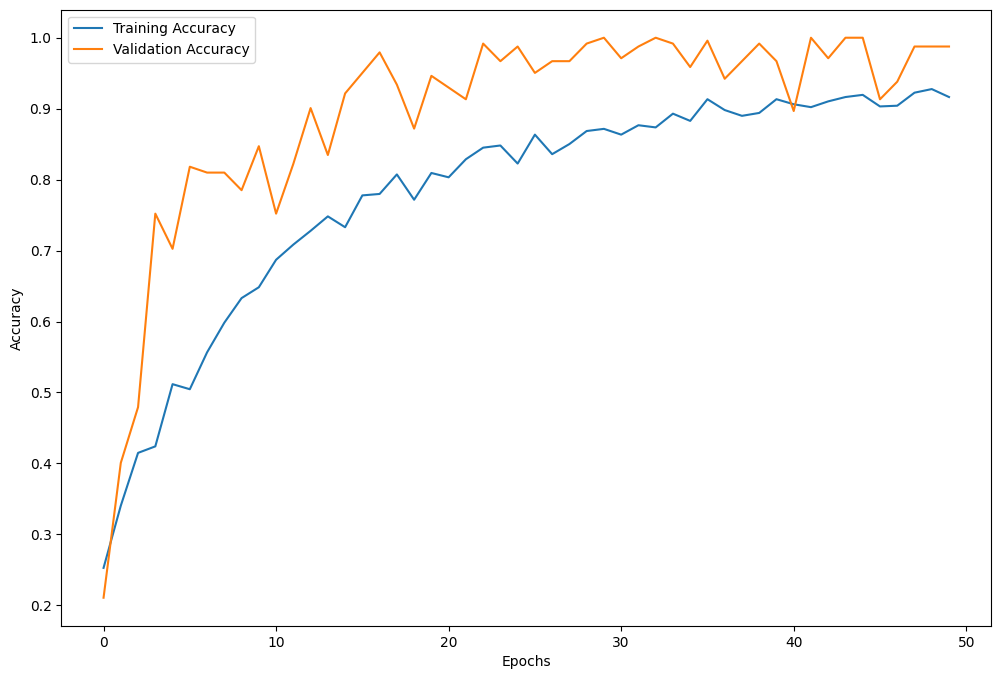

In [54]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

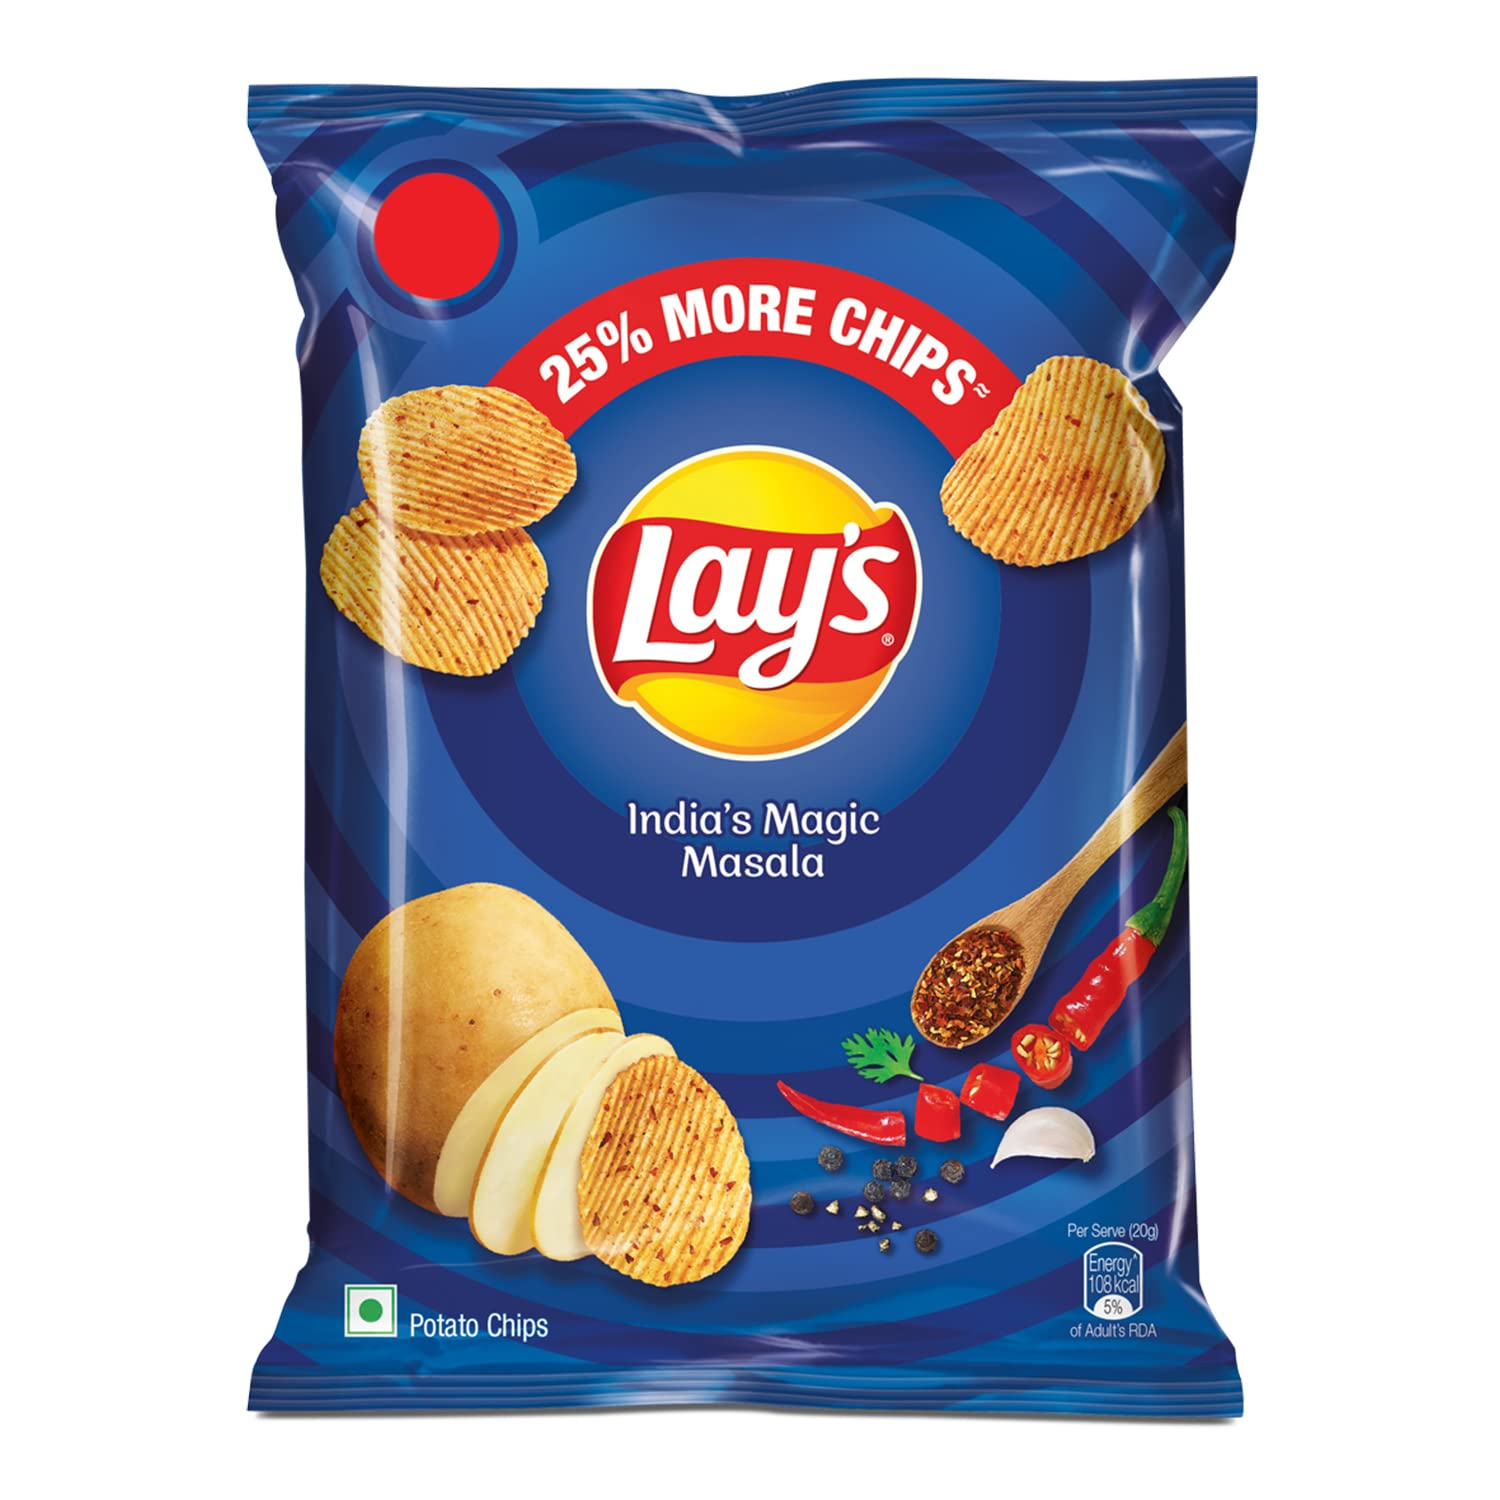

In [64]:
image = Image.open('sample/lays.jpg')

display(image)

In [65]:
test_image = image.resize((224,224))

test_image_arr = np.array(test_image)
if test_image_arr.shape[2] == 4:
    test_image_arr = test_image_arr[:, :, :3]
test_inp=test_image_arr.reshape((1,224,224,3))



# Check the shape of the array
print(test_image_arr.shape)  # This should be (224, 224, 3)

(224, 224, 3)


In [66]:
test_inp = test_inp.astype('float32')

test_inp /= 255.0

In [67]:
prediction=model.predict(test_inp)
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[2.4524648e-14, 9.9999833e-01, 1.7124594e-06, 4.8348738e-12,
        5.8497103e-11, 9.9332187e-09, 1.1840277e-09]], dtype=float32)

In [68]:
classes=['shampoo','chips','cake','fruit juice','chocolate','soft drinks','biscuit']

In [69]:
predicted_index = np.argmax(prediction)
print(classes[predicted_index])

chips


In [73]:
model.save_weights('custom_model.weights.h5')

In [76]:
# model.save('full_model.h5')
tf.keras.models.save_model(model, 'full_model.h5')

In [77]:
from tensorflow.keras.models import load_model
test=load_model('full_model.h5')

In [78]:
prediction=test.predict(test_inp)
predicted_class_index = np.argmax(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


In [79]:
print(predicted_class_index)

1
